# Evaluation and analysis of results

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
from pathlib import Path


## Dataset creation

In [2]:
# load data
local_path = Path("../llmSeminar/data/")
question_data = pd.read_excel(local_path / "questions_overview_answerFromTable.xlsx") # questions and tables metadata
results_b1 = pd.read_excel(local_path / "predictions/preds_answerFromTable_b1.xlsx") # evaluation of Simple zero-shot prompting (baseline)
results_b2 = pd.read_excel(local_path / "predictions/preds_answerFromTable_b2.xlsx") # evaluation of Zero-shot CoT
results_mcot = pd.read_excel(local_path / "predictions/preds_answerFromTable_mcot.xlsx") # evaluation of few-shot (manual) CoT


In [3]:
# concat evaluation of results to metadata df
results_df = pd.concat([question_data, pd.Series(list(results_b1["correct"]), name='correct_b1'), pd.Series(list(results_b2["correct"]), name='correct_b2'), pd.Series(list(results_mcot["correct"]), name='correct_mcot')], axis=1)

In [4]:
# create design variable
results_b1["design"] = "Baseline: Simple zero-shot"
results_b2["design"] = "Zero-shot CoT"
results_mcot["design"] = "Few-Shot CoT"
results_df_long = pd.concat([results_b1, results_b2, results_mcot])
results_df = pd.merge(results_df_long, question_data, on='question_uid', how='outer')

In [5]:
# rename values
results_df["category"] = results_df["category"].replace(['span (no comparison)', 'arithmetic', 'Multi-span', 'span (requires comparison)', 'count'], ['Lookup 1 (no comp.)', "Arithmetic", 'Lookup >1', "Lookup 1 (comp.)",'Count'])
results_df['category_finegrained'] = results_df['category_finegrained'].replace(['span (no comparison)', "span (requires comparison)", 'Multi-span', "total", "ratio", 'percentage of', 'percentage change', 'difference', 'average', 'count'], ['Lookup 1 (no comp.)', "Lookup 1 (comp.)", 'Lookup >1', "Total", "Ratio", 'Percentage of', 'Percentage change', 'Difference', 'Average', 'Count'])
results_df['table_size'] = results_df['table_small'].replace([True, False], ['Small tables', "Large tables"])

In [6]:
# reorder levels of question category (-> define order to be shown in plots)
question_categories = ["Lookup 1 (no comp.)", "Lookup 1 (comp.)", "Lookup >1", "Count", 'Arithmetic']
results_df["category"]= pd.Categorical(results_df["category"], categories = question_categories)

# reorder levels of "fine-grained" question category (-> define order to be shown in plots)
question_categories_finegrained = ["Lookup 1 (no comp.)", "Lookup 1 (comp.)", "Lookup >1", "Count", "Total", "Difference", "Ratio", "Percentage of", "Percentage change", "Average"]
results_df["category_finegrained"] = pd.Categorical(results_df["category_finegrained"], categories = question_categories_finegrained)

# reorder levels of table size (-> define order to be shown in plots)
table_sizes = ["Small tables", "Large tables"]
results_df["table_size"] = pd.Categorical(results_df["table_size"], categories = table_sizes)


In [7]:
results_df.head()

,question_uid,gptAnswer,extractedAnswer,derivation,label,scale,note,correct,problem,ValueDetectionError,...,table_uid,answer_from,category,category_finegrained,table_col_no,table_row_no,table_colxrow,table_small,paragraphs_word_no,table_size
0,921d80d2-1ea6-4c31-bf06-6393e5ca70ab,The U.S. tax reform charge in 2019 was $146 mi...,$146 million,NaN,['146'],million,NaN,True,NaN,False,...,f3c0118e-20f3-416c-a52b-b3a7743bc1a7,table,Lookup 1 (no comp.),Lookup 1 (no comp.),4,11,44,False,45,Large tables
1,921d80d2-1ea6-4c31-bf06-6393e5ca70ab,"According to the table, the U.S. tax reform ch...",$146 million,NaN,['146'],million,NaN,True,NaN,False,...,f3c0118e-20f3-416c-a52b-b3a7743bc1a7,table,Lookup 1 (no comp.),Lookup 1 (no comp.),4,11,44,False,45,Large tables
2,921d80d2-1ea6-4c31-bf06-6393e5ca70ab,The U.S. tax reform charge in 2019 was $146 mi...,$146 million,NaN,['146'],million,NaN,True,NaN,False,...,f3c0118e-20f3-416c-a52b-b3a7743bc1a7,table,Lookup 1 (no comp.),Lookup 1 (no comp.),4,11,44,False,45,Large tables
3,82233a8d-8e3d-4d17-ae97-ba62b4a8ba70,"The total revenue between 2017 to 2019 is $1,5...","$1,536.7 million","1,536.7+1,378.2+1,065.7",3980.6,million,NaN,False,"values missing,calculation missing",True,...,ee234fba-b422-4f1e-b383-721e1fbf8a1f,table,Arithmetic,Total,4,16,64,False,88,Large tables
4,82233a8d-8e3d-4d17-ae97-ba62b4a8ba70,To calculate the total revenue between 2017 to...,"$3,980.6 million","1,536.7+1,378.2+1,065.7",3980.6,million,NaN,True,NaN,False,...,ee234fba-b422-4f1e-b383-721e1fbf8a1f,table,Arithmetic,Total,4,16,64,False,88,Large tables


## Performance Analysis 
Performance measure: accuracy (percentage of correctly answered questions)

In [8]:
# define font and fontsize of plots (adjust to report font)
font = {'family' : 'serif',
        'size'   : 14}

plt.rc('font', **font)

### overall accuracy per design

design                      correct
Baseline: Simple zero-shot  True       0.56
                            False      0.44
Few-Shot CoT                True       0.63
                            False      0.37
Zero-shot CoT               True       0.65
                            False      0.35
Name: proportion, dtype: float64


<Axes: xlabel='design'>

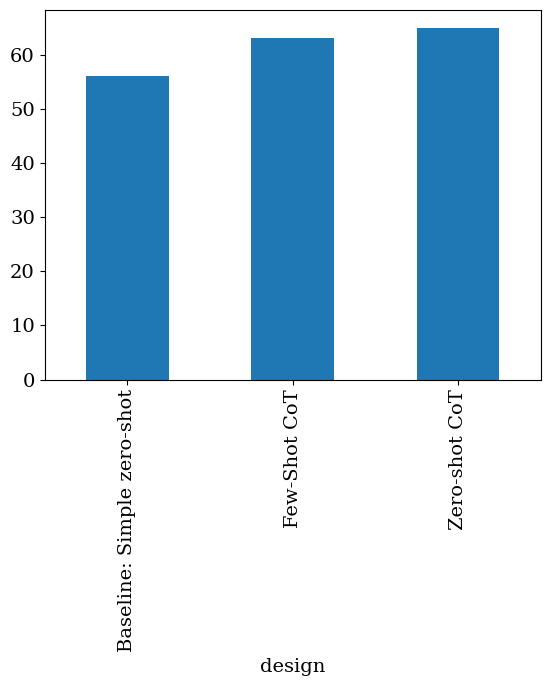

In [9]:
print(results_df.groupby(["design"])["correct"].value_counts(normalize=True))

#plot: accuracy by prompt setting
results_df[results_df.correct == True].groupby(['design']).size().plot(kind = "bar")

### accuracy by table size

In [10]:
# accuracy by table size
print(results_df.groupby(["table_size", "design"])["correct"].value_counts(normalize=True))

table_size    design                      correct
Small tables  Baseline: Simple zero-shot  True       0.66
                                          False      0.34
              Few-Shot CoT                True       0.72
                                          False      0.28
              Zero-shot CoT               True       0.70
                                          False      0.30
Large tables  Baseline: Simple zero-shot  False      0.54
                                          True       0.46
              Few-Shot CoT                True       0.54
                                          False      0.46
              Zero-shot CoT               True       0.60
                                          False      0.40
Name: proportion, dtype: float64


/tmp/ipykernel_72769/3730968520.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(results_df.groupby(["table_size", "design"])["correct"].value_counts(normalize=True))


/tmp/ipykernel_72769/4052343932.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df_tabSize = results_df.groupby(["table_size", 'design'])['correct'].mean() * 100


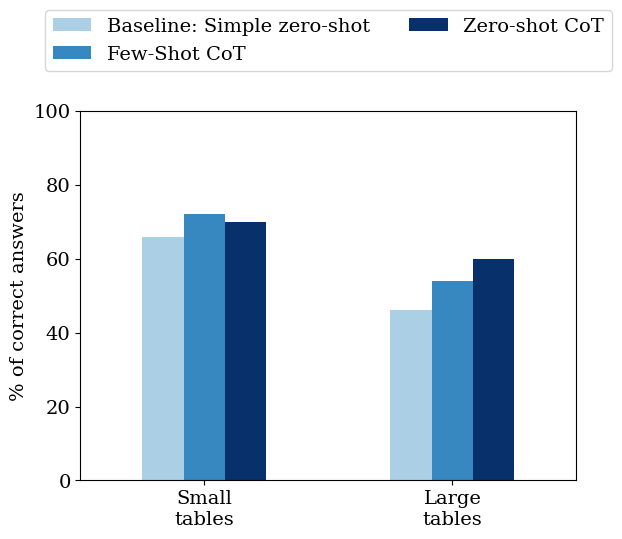

In [11]:
# plot: accuracy by prompt setting and table size

# create grouped df
grouped_df_tabSize = results_df.groupby(["table_size", 'design'])['correct'].mean() * 100

# create a color map for each design
unique_values_cat = results_df['design'].unique()
color_dict = {value: plt.cm.Blues_r((len(unique_values_cat) - i - 1) / len(unique_values_cat)) for i, value in enumerate(unique_values_cat)}

# Map the colors to the designs
grouped_df_colors = results_df['design'].map(color_dict)

# Plot the bar chart with different colors for each design
ax = grouped_df_tabSize.unstack('design').plot(kind='bar', ylabel='% of correct answers', color=grouped_df_colors)

#legend and labels
ax.legend(title='', bbox_to_anchor=(0.5, 1.3), ncol=2, loc="upper center") # hide legend title, define position and display
labels = [item.get_text() for item in ax.get_xticklabels()]
wrapped_labels = [('\n'.join(textwrap.wrap(label, width=10))) if len(label) > 10 else label for label in labels]
ax.set_xticklabels(wrapped_labels)
ax.xaxis.set_tick_params(rotation=0)
ax.set_xlabel('')  # Hide x-axis label

plt.ylim(0, 100)

# Show the plot
plt.show()

### accuracy by question category
- overall
- separately for small and large tables

In [12]:
# accuracy by category and design
print(results_df.groupby(["category_finegrained", "design"])["correct"].value_counts(normalize=True))

category_finegrained  design                      correct
Lookup 1 (no comp.)   Baseline: Simple zero-shot  True       1.0
                                                  False      0.0
                      Few-Shot CoT                True       0.9
                                                  False      0.1
                      Zero-shot CoT               True       0.9
                                                  False      0.1
Lookup 1 (comp.)      Baseline: Simple zero-shot  True       0.8
                                                  False      0.2
                      Few-Shot CoT                True       0.8
                                                  False      0.2
                      Zero-shot CoT               True       0.8
                                                  False      0.2
Lookup >1             Baseline: Simple zero-shot  False      0.6
                                                  True       0.4
                      Few-Shot C

/tmp/ipykernel_72769/2345484528.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(results_df.groupby(["category_finegrained", "design"])["correct"].value_counts(normalize=True))


In [14]:
# aggregate arithmetic categories
print(results_df[results_df.category == "Arithmetic"].groupby(["design"])["correct"].value_counts(normalize=True))

# by table size
print(results_df[results_df.category == "Arithmetic"].groupby(["table_size", "design"])["correct"].value_counts(normalize=True))

design                      correct
Baseline: Simple zero-shot  False      0.533333
                            True       0.466667
Few-Shot CoT                True       0.533333
                            False      0.466667
Zero-shot CoT               True       0.583333
                            False      0.416667
Name: proportion, dtype: float64
table_size    design                      correct
Small tables  Baseline: Simple zero-shot  True       0.600000
                                          False      0.400000
              Few-Shot CoT                True       0.666667
                                          False      0.333333
              Zero-shot CoT               True       0.666667
                                          False      0.333333
Large tables  Baseline: Simple zero-shot  False      0.666667
                                          True       0.333333
              Few-Shot CoT                False      0.600000
                                   

/tmp/ipykernel_72769/903597618.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(results_df[results_df.category == "Arithmetic"].groupby(["table_size", "design"])["correct"].value_counts(normalize=True))


/tmp/ipykernel_72769/3115495445.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df_cat = results_df.groupby(["category_finegrained", 'design'])['correct'].mean() * 100
/tmp/ipykernel_72769/3115495445.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df_cat_smallTab = results_df[results_df["table_small"] == True].groupby(["category_finegrained", 'design'])['correct'].mean() * 100
/tmp/ipykernel_72769/3115495445.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observ

Accuracy by design and question category


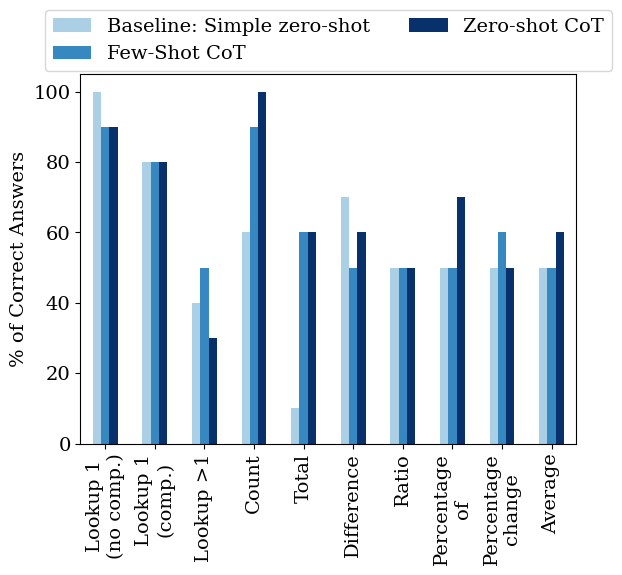

Accuracy by design and question category for small tables


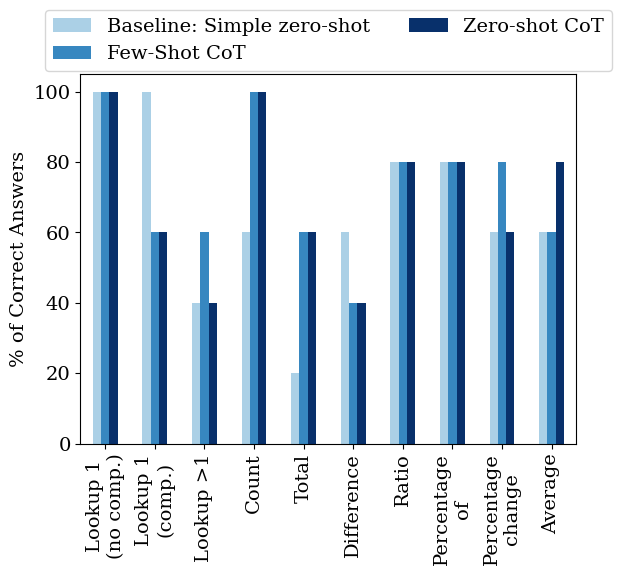

Accuracy by design and question category for large tables


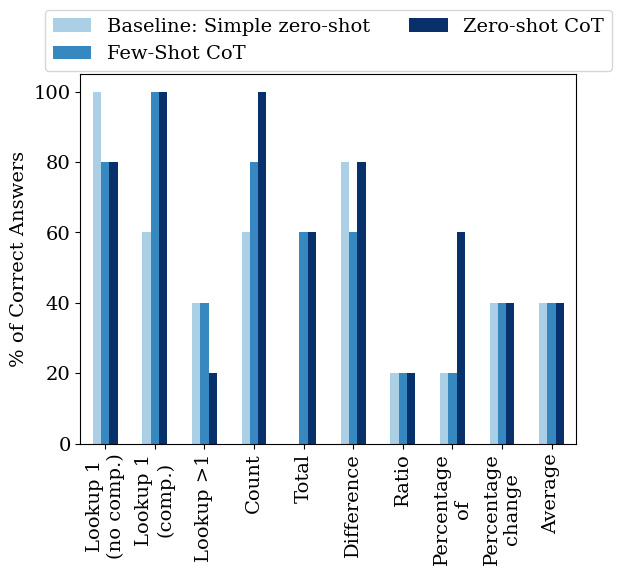

In [15]:
#plots

# create grouped dfs
grouped_df_cat = results_df.groupby(["category_finegrained", 'design'])['correct'].mean() * 100
grouped_df_cat_smallTab = results_df[results_df["table_small"] == True].groupby(["category_finegrained", 'design'])['correct'].mean() * 100
grouped_df_cat_largeTab = results_df[results_df["table_small"] == False].groupby(["category_finegrained", 'design'])['correct'].mean() * 100

grouped_dfs = [grouped_df_cat, grouped_df_cat_smallTab, grouped_df_cat_largeTab]
titles = ["Accuracy by design and question category", "Accuracy by design and question category for small tables", "Accuracy by design and question category for large tables"]


for i in range(3):

    print(titles[i])
    df = grouped_dfs[i]
    
    # Plot the bar chart with different colors for each design (as defined above)
    ax = df.unstack('design').plot(kind='bar', ylabel='% of Correct Answers', color=grouped_df_colors)

    # legend
    ax.legend(title='', bbox_to_anchor=(0.5, 1.2), ncol=2, loc="upper center")

    # display of xlabels
    labels = [item.get_text() for item in ax.get_xticklabels()]
    wrapped_labels = [('\n'.join(textwrap.wrap(label, width=10))) if len(label) > 10 else label for label in labels]
    ax.set_xticklabels(wrapped_labels)
    ax.set_xlabel('')  # Hide x-axis label
    
    # Show the plot
    plt.show()

Accuracy by design and question category


/tmp/ipykernel_72769/3450584196.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df_cat = results_df.groupby(["category", 'design'])['correct'].mean() * 100
/tmp/ipykernel_72769/3450584196.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df_cat_smallTab = results_df[results_df["table_small"] == True].groupby(["category", 'design'])['correct'].mean() * 100
/tmp/ipykernel_72769/3450584196.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the fut

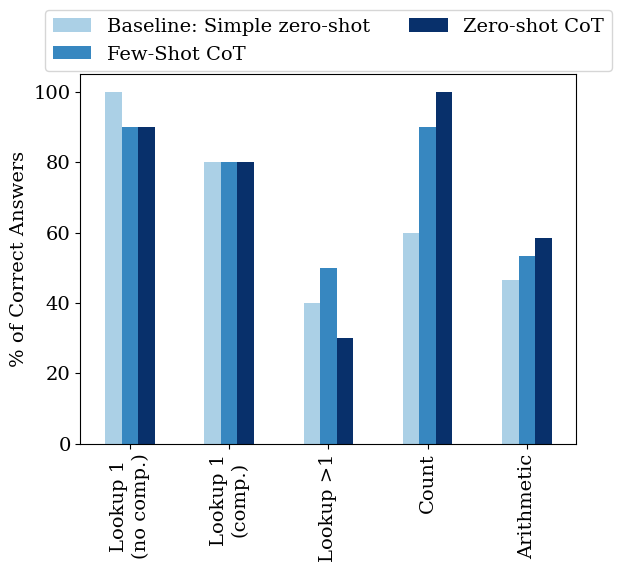

Accuracy by design and question category for small tables


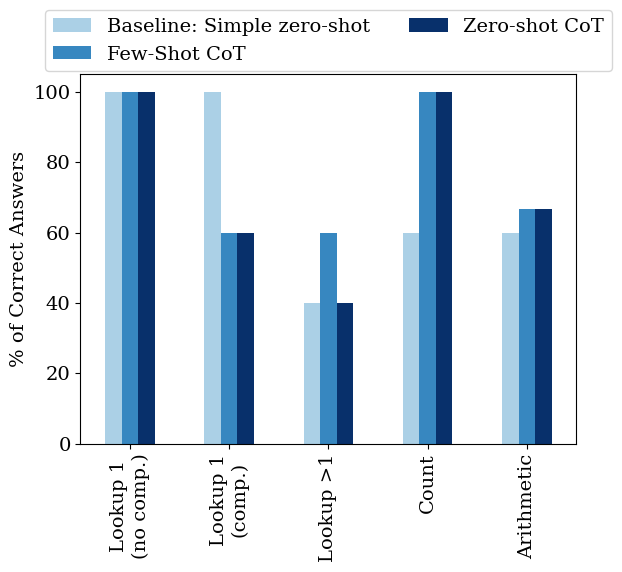

Accuracy by design and question category for large tables


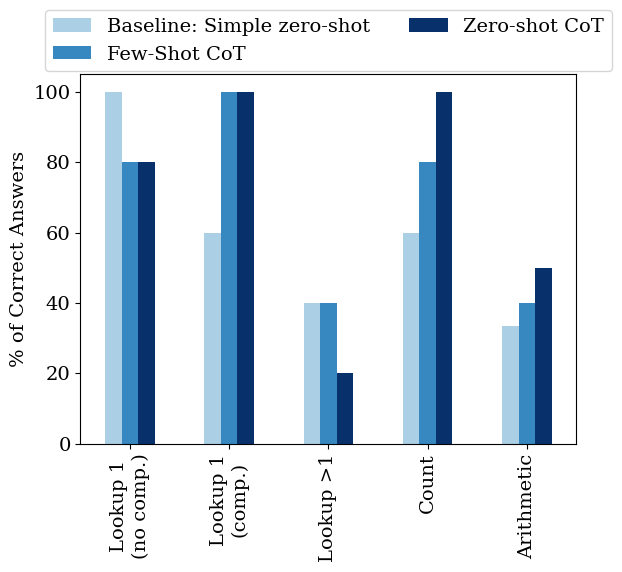

In [16]:
#plots: using "coarse-grained" question categories (aggregating arithmetic questions)

# create grouped dfs
grouped_df_cat = results_df.groupby(["category", 'design'])['correct'].mean() * 100
grouped_df_cat_smallTab = results_df[results_df["table_small"] == True].groupby(["category", 'design'])['correct'].mean() * 100
grouped_df_cat_largeTab = results_df[results_df["table_small"] == False].groupby(["category", 'design'])['correct'].mean() * 100

grouped_dfs = [grouped_df_cat, grouped_df_cat_smallTab, grouped_df_cat_largeTab]
titles = ["Accuracy by design and question category", "Accuracy by design and question category for small tables", "Accuracy by design and question category for large tables"]


for i in range(3):

    print(titles[i])
    df = grouped_dfs[i]
    
    # Plot the bar chart with different colors for each design (as defined above)
    ax = df.unstack('design').plot(kind='bar', ylabel='% of Correct Answers', color=grouped_df_colors)

    # legend
    ax.legend(title='', bbox_to_anchor=(0.5, 1.2), ncol=2, loc="upper center")

    # display of xlabels
    labels = [item.get_text() for item in ax.get_xticklabels()]
    wrapped_labels = [('\n'.join(textwrap.wrap(label, width=10))) if len(label) > 10 else label for label in labels]
    ax.set_xticklabels(wrapped_labels)
    ax.set_xlabel('')  # Hide x-axis label
    
    # Show the plot
    plt.show()

/tmp/ipykernel_72769/1937856418.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df_cat = results_df[results_df["category"] == "Arithmetic"].groupby(["category_finegrained", 'design'])['correct'].mean() * 100
/tmp/ipykernel_72769/1937856418.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df_cat_smallTab = results_df[(results_df["table_small"] == True) & (results_df["category"] == "Arithmetic")].groupby(["category_finegrained", 'design'])['correct'].mean() * 100
/tmp/ipykernel_72769/1937856418.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in

Accuracy by design and question category


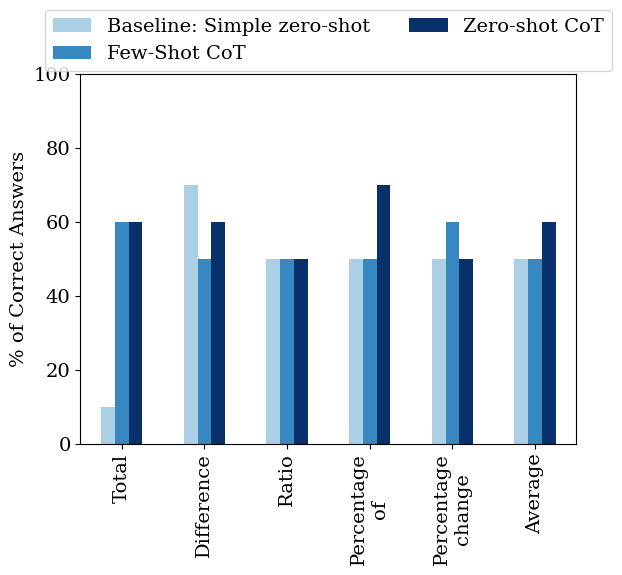

Accuracy by design and question category for small tables


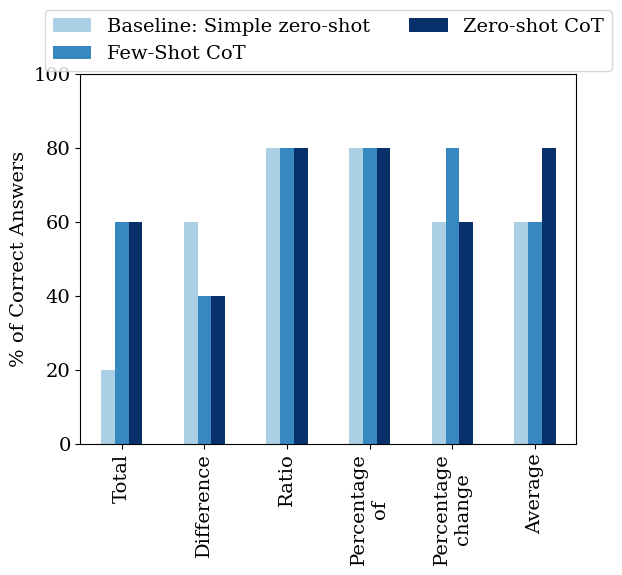

Accuracy by design and question category for large tables


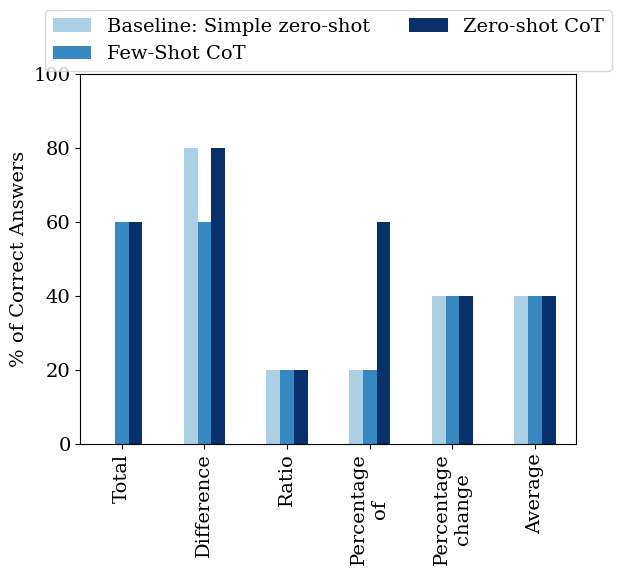

In [17]:
#plots: only arithmetic categories

# create grouped dfs
grouped_df_cat = results_df[results_df["category"] == "Arithmetic"].groupby(["category_finegrained", 'design'])['correct'].mean() * 100
grouped_df_cat_smallTab = results_df[(results_df["table_small"] == True) & (results_df["category"] == "Arithmetic")].groupby(["category_finegrained", 'design'])['correct'].mean() * 100
grouped_df_cat_largeTab = results_df[(results_df["table_small"] == False) & (results_df["category"] == "Arithmetic")].groupby(["category_finegrained", 'design'])['correct'].mean() * 100

grouped_dfs = [grouped_df_cat, grouped_df_cat_smallTab, grouped_df_cat_largeTab]
titles = ["Accuracy by design and question category", "Accuracy by design and question category for small tables", "Accuracy by design and question category for large tables"]


for i in range(3):

    print(titles[i])
    df = grouped_dfs[i]
    
    # Plot the bar chart with different colors for each design (as defined above)
    ax = df.unstack('design').plot(kind='bar', ylabel='% of Correct Answers', color=grouped_df_colors)

    # legend
    ax.legend(title='', bbox_to_anchor=(0.5, 1.2), ncol=2, loc="upper center")

    # display of xlabels
    labels = [item.get_text() for item in ax.get_xticklabels()]
    wrapped_labels = [('\n'.join(textwrap.wrap(label, width=10))) if len(label) > 10 else label for label in labels]
    ax.set_xticklabels(wrapped_labels)
    ax.set_xlabel('')  # Hide x-axis label

    plt.ylim(0, 100)
    plt.xlim(3.5, 9.5)
    
    # Show the plot
    plt.show()

## Error analysis

- error types were manually defined and labelled using one-hot-encoding so that they can be overlapping.
- identtified error types: *ValueDetectionError*, *ScaleError*, *FormulaError*, *CalculationError*, *RoundingError*, *MissingCalculationError*, *MisunderstandingError*, *OtherError*

### Error types by question category

In [23]:
error_types = ["ValueDetectionError", "ScaleError", "FormulaError", "CalculationError", "RoundingError", "MissingCalculationError", "MisunderstandingError", "OtherError"]

# print percentage of errors that occur in each question type (can be overlapping)
for cat in question_categories_finegrained:
    print(cat)
    for error in error_types:
        error_percent = results_df[(results_df["correct"]==False) & (results_df.category_finegrained == cat)][error].mean() * 100
        if (error_percent != 0):
            print(f"{error_percent} % {error}")
    print("\n")

Lookup 1 (no comp.)
50.0 % ValueDetectionError
50.0 % MisunderstandingError


Lookup 1 (comp.)
33.33333333333333 % ValueDetectionError
66.66666666666666 % MisunderstandingError


Lookup >1
16.666666666666664 % ValueDetectionError
11.11111111111111 % ScaleError
5.555555555555555 % MissingCalculationError
55.55555555555556 % MisunderstandingError
11.11111111111111 % OtherError


Count
80.0 % ValueDetectionError
20.0 % OtherError


Total
11.76470588235294 % ValueDetectionError
29.411764705882355 % ScaleError
23.52941176470588 % FormulaError
17.647058823529413 % MissingCalculationError
23.52941176470588 % MisunderstandingError
5.88235294117647 % OtherError


Difference
25.0 % ValueDetectionError
16.666666666666664 % ScaleError
66.66666666666666 % FormulaError


Ratio
53.333333333333336 % ValueDetectionError
60.0 % FormulaError
20.0 % CalculationError
6.666666666666667 % MissingCalculationError


Percentage of
30.76923076923077 % ValueDetectionError
69.23076923076923 % RoundingError


Perce

In [27]:
# create df for plotting
error_perc_df = [['category_finegrained', 'error_type','error_percent']]

for cat in question_categories_finegrained:
    for error in error_types:
        error_percent = results_df[(results_df["correct"]==False) & (results_df.category_finegrained == cat)][error].mean() * 100
        row = [cat, error, error_percent]
        
        error_perc_df.append(row)

error_perc_df = pd.DataFrame(error_perc_df[1:],columns=error_perc_df[0])

# reorder levels of question category (-> define order to be shown in plot)
error_perc_df["category_finegrained"] = pd.Categorical(error_perc_df["category_finegrained"], categories = question_categories_finegrained)

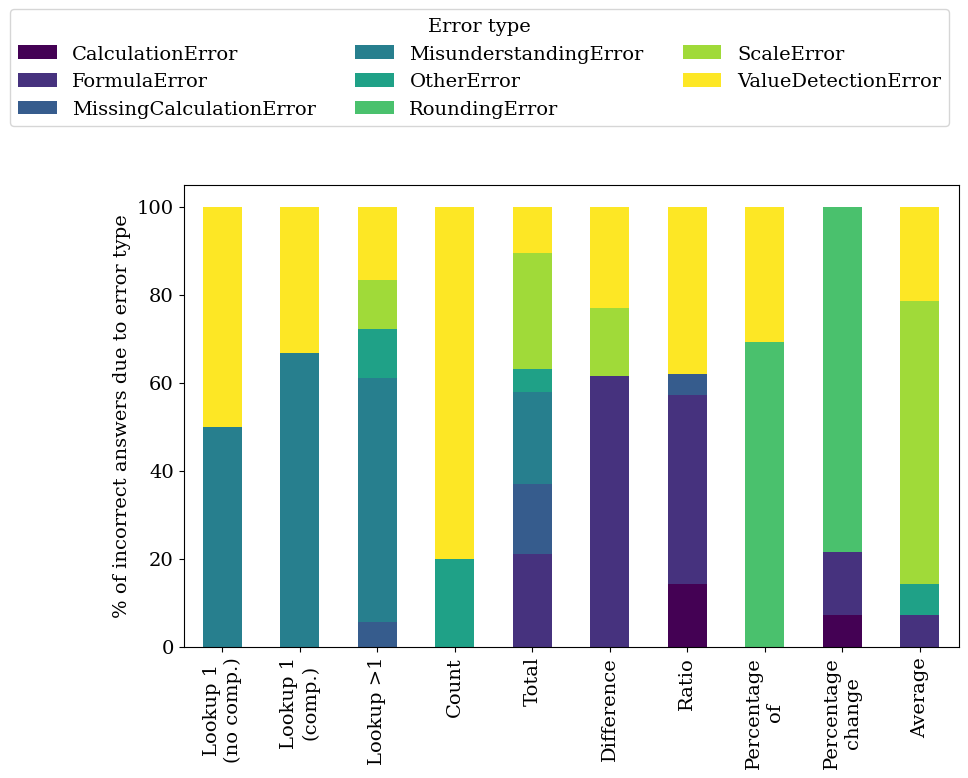

In [29]:
# pivot the DataFrame
pivot_df = error_perc_df.pivot(index='category_finegrained', columns='error_type', values='error_percent')

# Normalize each row to represent percentages
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Plot as stacked bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='viridis')

# labels and legend (dont use title in report)
plt.xlabel('')
plt.ylabel('% of incorrect answers due to error type')
plt.legend(title='Error type', bbox_to_anchor=(1, 1.4), ncol=3) # define position and display

# adjust display of xlabels
labels = [item.get_text() for item in ax.get_xticklabels()]
wrapped_labels = [('\n'.join(textwrap.wrap(label, width=10))) if len(label) > 10 else label for label in labels]
ax.set_xticklabels(wrapped_labels)

# plot
plt.show()


### Error types by prompt setting

In [21]:
# create df for plotting
error_perc_byDesign_df = [['design','error_type','error_percent']]

for d in list(results_df["design"].unique()):
    for error in error_types:
        error_percent = results_df[(results_df["correct"]==False) & (results_df.design == d)][error].mean() * 100
        row = [d, error, error_percent]
        
        error_perc_byDesign_df.append(row)

error_perc_byDesign_df = pd.DataFrame(error_perc_byDesign_df[1:],columns=error_perc_byDesign_df[0])

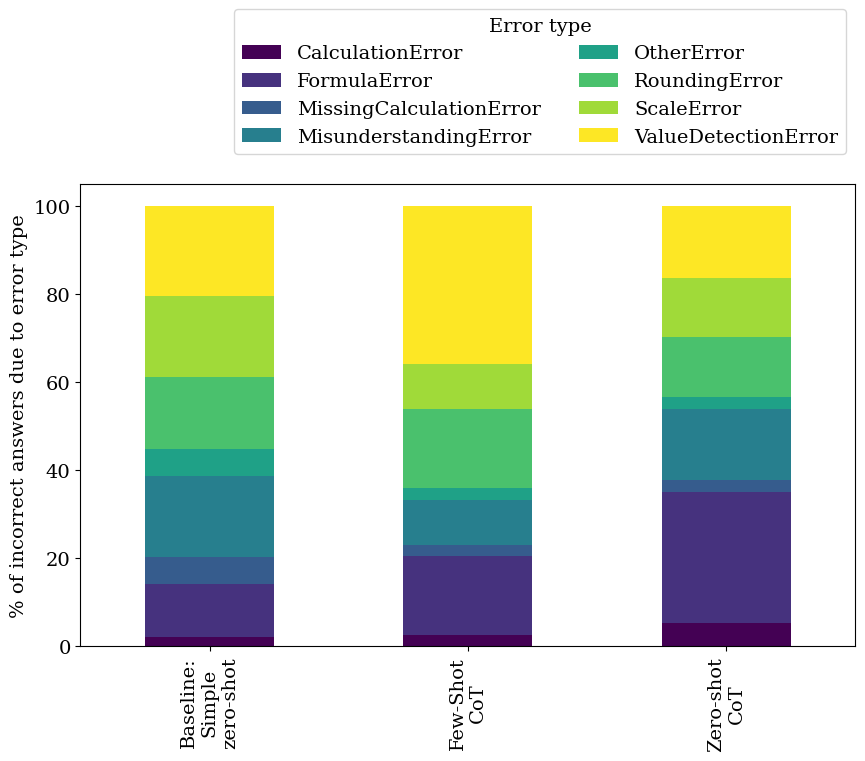

In [22]:
# Pivot the DataFrame
pivot_df = error_perc_byDesign_df.pivot(index='design', columns='error_type', values='error_percent')

# Normalize each row to represent percentages
pivot_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Plot as stacked bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6), cmap='viridis')

# labels and legend
plt.xlabel('')
plt.ylabel('% of incorrect answers due to error type')
plt.legend(title='Error type', bbox_to_anchor=(1, 1.4), ncol=2)

labels = [item.get_text() for item in ax.get_xticklabels()]
wrapped_labels = [('\n'.join(textwrap.wrap(label, width=10))) if len(label) > 10 else label for label in labels]
ax.set_xticklabels(wrapped_labels)

# show plot
plt.show()
